In [ ]:
!pip install diffrax

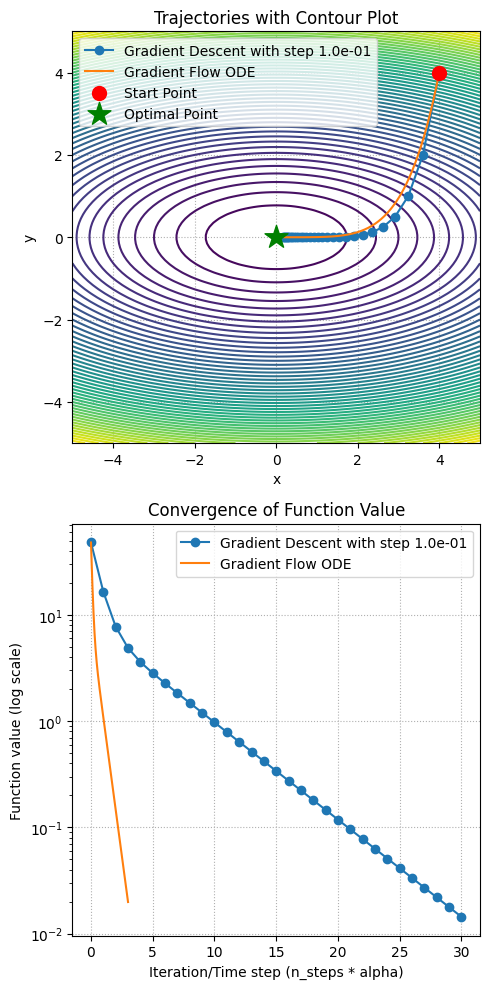

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import jax.numpy as jnp
from jax import grad

# Quadratic function setup
A = np.array([[1., 0], [0, 5.]])  # Simple positive definite matrix
alpha = 1e-1
num_steps = 30
t_final = alpha*num_steps
quadratic_function = lambda x: 0.5 * x.T @ A @ x
grad_quadratic_function = grad(lambda x: 0.5 * x.T @ A @ x)

# Plot contours function
def plot_contours(function, x_range, y_range, resolution=100):
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)  # Initialize Z with the correct shape
    
    # Compute the function value for each point on the grid
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = function(np.array([X[i, j], Y[i, j]]))
    
    plt.contour(X, Y, Z, levels=50, cmap='viridis')


# Gradient Descent Method
def gradient_descent(grad_func, start_point, learning_rate=0.1, num_steps=50):
    trajectory = [start_point]
    x = start_point
    for _ in range(num_steps):
        grad = grad_func(x)
        x = x - learning_rate * grad
        trajectory.append(x)
    return np.array(trajectory)

# Gradient Flow ODE
def vector_field(t, y, args):
    return -grad_quadratic_function(y)

def solve_ode(vector_field, start_point, t0=0, t1=t_final, dt0=1e-2):
    term = ODETerm(vector_field)
    solver = Dopri5()
    ts=np.linspace(t0, t1, 300)
    saveat = SaveAt(ts=ts)
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
    sol = diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, y0=start_point, saveat=saveat,
                      stepsize_controller=stepsize_controller)
    return np.array(sol.ys), ts

# Setup
start_point = np.array([4.0, 4.0])

# Solve trajectories
trajectory_gd = gradient_descent(grad_quadratic_function, start_point, alpha, num_steps)
trajectory_gf, ts = solve_ode(vector_field, start_point)

# Plotting
plt.figure(figsize=(5, 10))

# Left subplot for contour and trajectories
plt.subplot(2, 1, 1)
plot_contours(quadratic_function, x_range=(-5, 5), y_range=(-5, 5))
plt.plot(trajectory_gd[:, 0], trajectory_gd[:, 1], 'o-',  label=f'Gradient Descent with step {alpha:.1e}')
plt.plot(trajectory_gf[:, 0], trajectory_gf[:, 1], '-', label='Gradient Flow ODE')
plt.scatter(*start_point, color='red', marker='o', s=100, zorder=5, label='Start Point')
plt.scatter(0, 0, color='green', marker='*', s=300, zorder=5, label='Optimal Point')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories with Contour Plot')
plt.legend()
plt.grid(linestyle=":")

# Right subplot for semilogy convergence
plt.subplot(2, 1, 2)
function_values_gd = [quadratic_function(x) for x in trajectory_gd]
function_values_gf = [quadratic_function(x) for x in trajectory_gf]
plt.semilogy(function_values_gd, 'o-', label=f'Gradient Descent with step {alpha:.1e}')
plt.semilogy(ts, function_values_gf, '-', label='Gradient Flow ODE')
plt.xlabel('Iteration/Time step (n_steps * alpha)')
plt.ylabel('Function value (log scale)')
plt.title('Convergence of Function Value')
plt.grid(linestyle=":")
plt.legend()

plt.tight_layout()
plt.savefig("GD_vs_GF.pdf")
plt.show()
